# Computer Lab : Natural Language Processing 
### Authors : Rémi Ducottet and Eliott Henry

### Import of librairies and data

In [6]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import time

In [7]:
# Fonction qui permet de load les données

def load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',
	      file_name_labels='train_labels.npy', samples_in_train_set=10000,
	      samples_in_test_set=137562):
	# Recuperation des donnees
	TF_IDF_matrix = sp.load_npz(file_name_matrix)
	TF_IDF_feature_names = np.load(file_name_feature_names)
	train_labels = np.load(file_name_labels, allow_pickle=True)
	train_labels_numeric = ((train_labels == 'Oui') + 0)

	X = TF_IDF_matrix[:samples_in_train_set].toarray()
	y = train_labels_numeric[:samples_in_train_set] * 2 - 1

	X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
	y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


	# Standardisation des données
	std_X = np.maximum(np.std(X, axis=0), 1e-7)
	X = X / std_X
	X_test = X_test / std_X

	n = X.shape[0]
	n_test = X_test.shape[0]
	m = X.shape[1]

	# Ajout d'une colonne de uns
	eX = np.hstack((np.ones((n,1)), X))
	eX_test = np.hstack((np.ones((n_test,1)), X_test))

	return eX, y, eX_test, y_test

In [8]:
eX, Y, eX_test, y_test = load_data()
n,p = eX.shape
rho = 1/n

In [9]:
print(n)
print(p)

10000
576


### Question 3.1

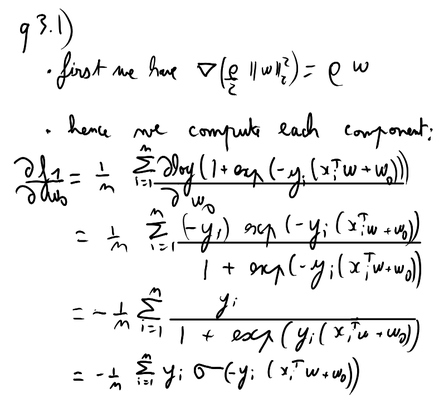

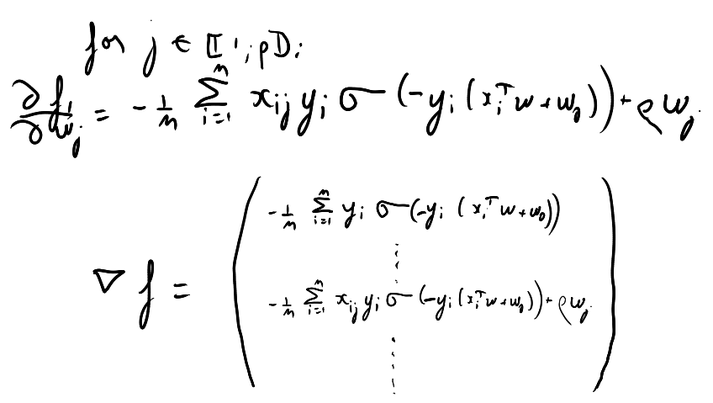

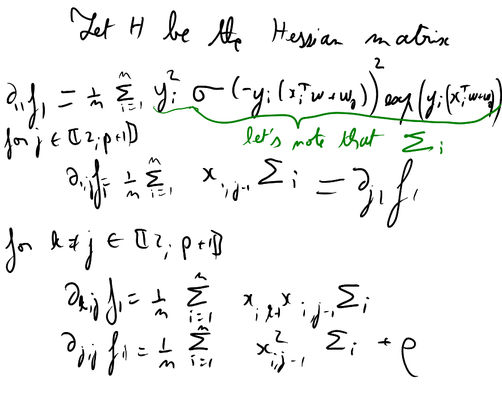


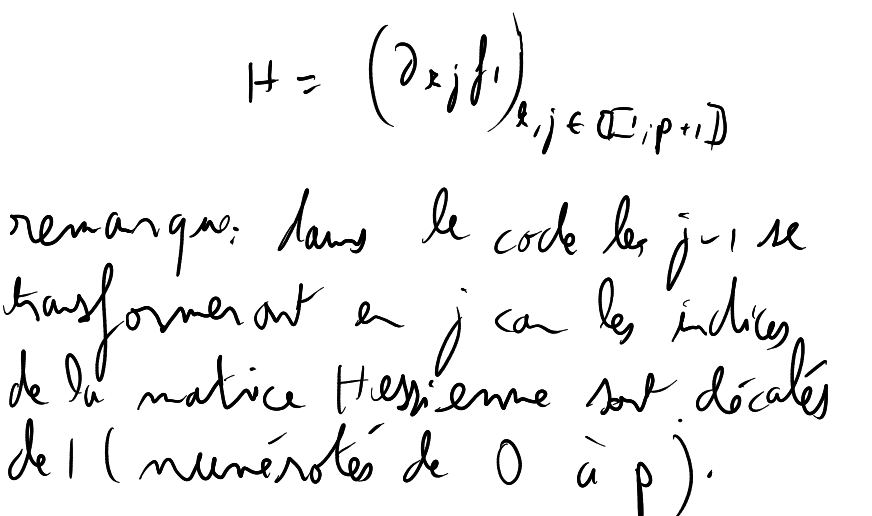

### Question 3.2

In [14]:
# Fonction intermédiaire
def terme_dans_sigma(i,w0,W):
    return -Y[i-1]*(np.dot(eX[i-1].T, W)+w0)

# Fonction f1
def f1(W_param):
    w0 = W_param[0]
    W = W_param[1:]
    S=0
    for i in range(n):
        S+=np.log(1+np.exp(terme_dans_sigma(i,w0,W)))+rho/2*np.linalg.norm(W)**2
    return S/n

# Fonction intermédiraire
def sigma(i,w0,W):
    return 1/(1+np.exp(-terme_dans_sigma(i,w0,W)))

# Gradient de f1
def gradf1(W_param):
    w0 = W_param[0]
    W = W_param[1:]
    grad=[]
    grad_0 = -(1/n)*sum(Y[i-1]*sigma(i,w0,W) for i in range (1,n+1))
    grad.append(grad_0)
    for j in range (1,p+1):
        grad_j = (-1/n)*sum(eX[i][j-1]*Y[i-1]*sigma(i,w0,W) for i in range (1,n+1))+rho*W[j-1]
        grad.append(grad_j)
    return grad
        
# Fonction intermédiaire
def Sigma(i,w0,W):
    return Y[i-1]**2*sigma(i,w0,W)**2*np.exp(-1*terme_dans_sigma(i,w0,W))

# Matrice hessienne de f1                              
def Hessian(W_param):
    w0 = W_param[0]
    W = W_param[1:]
    Hess= np.zeros((p+1,p+1))
    Hess[0][0]=1/n*sum(Sigma(i,w0,W) for i in range (1,n+1))
    for j in range (1,p+1):
        Hess[0][j]=1/n*sum(Sigma(i,w0,W)*eX[i][j] for i in range (1,n+1))
        Hess[j][0]=Hess[0][j]
        Hess[j][j]=1/n*sum(Sigma(i,w0,W)*eX[i][j] for i in range (1,n+1))+rho
        for k in range (1, j):
            Hess[k][j]=1/n*sum(Sigma(i,w0,W)*eX[i][j]*eX[i][k] for i in range (1,n+1))
            Hess[j][k]=Hess[k][j]

In [15]:
# Test avec les valeurs initiales
W_test_grad = [1] * (p+1)
g = gradf1(W_test_grad)


In [16]:
print(len(g))

577


In [17]:
## Check whether our function grad is a good approximation of the actual gradient of f in this interval
check_grad(f1, gradf1, W_test_grad)

0.024002301640076718

### Question 3.3

In [26]:
def newton(W_init, epsilon):
    
    W_param = W_init
    
    f = f1(W_param) 
    grad = gradf1(W_param) 
    H = Hessian(W_param)
    norme = norm(grad)

    i = 0
    norms = [norme]

    while(norm(grad) < epsilon):
        f = f1(W_param)
        grad = gradf1(W_param) 
        H = Hessian(W_param)
        
        W_param = W_param - np.matmul(np.linalg.invert(H), np(grad))
        norms.append(norm(grad))
        i+=1
    
    x_plot = np.log(np.arrange(0, i))
    plt.plot(x_plot, norms)
    plt.show()
    
    return W_param

In [ ]:
W_init = np.zeros(p+1)
epsilon = 10**(-10)

W_min = newton(W_init, epsilon)